<a href="https://colab.research.google.com/github/Ian-Sinclair/Computer-Vision-tinyYolo-Character-Detection/blob/main/ENCE_4620_Project_5_Ian_Sinclair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 20 15:06:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Imports: Darkflow (YOLO) and Tensorflow

In [ ]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import numpy as np

In [ ]:


from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Install required libraries
#!pip install tensorflow-gpu==1.15.0rc2
!pip install tensorflow-gpu==1.15.0
!pip install imageio

# Download and build darkflow (the tensorflow implementation of YOLO)
import os
import pathlib

if "darkflow-master" in pathlib.Path.cwd().parts:
  while "darkflow-master" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path("darkflow-master").exists():
  !git clone --depth 1 https://github.com/thtrieu/darkflow.git
  # Compile darkflow
  %cd darkflow
  !python setup.py build_ext --inplace
  # Change darkflow to darkflow-master to distinguish between folder names
  %cd ../
  !mv darkflow darkflow-master
  %cd darkflow-master


# Upload yolo.weights, pre-trained weights file (for YOLO v2) from an external Google drive 
weights = 'yolo'
weights_file = weights + '.weights'
if not os.path.exists('weights_file'):
  !gdown --id 0B1tW_VtY7oniTnBYYWdqSHNGSUU
  !mkdir bin
  !mv yolo.weights bin


# Imports
%cd darkflow-master
%tensorflow_version 1.15.0rc2

# For importing/exporting files, working with arrays, etc
import time
import urllib
import numpy as np
import pandas as pd
import imageio

# For actual object detection
import tensorflow as tf
from darkflow.net.build import TFNet
threshold = 0.25

# For drawing onto and plotting images
import matplotlib.pyplot as plt
import cv2
%config InlineBackend.figure_format = 'svg'

     |████████████████████████████████| 411.5 MB 6.8 kB/s 
     |████████████████████████████████| 503 kB 66.2 MB/s 
     |████████████████████████████████| 50 kB 8.5 MB/s 
     |████████████████████████████████| 3.8 MB 58.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=024295a16a90057fcb85b7477c6c95b6dcb842d8d023681abb4b540b0436bd65
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succe

Define a Model:

In [ ]:
params = {
    'model': 'cfg/yolo.cfg',
    'load': 'bin/yolo.weights',
    'threshold': threshold, 
    'gpu': 0.0
}

# Run the model
tfnet = TFNet(params)

Parsing ./cfg/yolo.cfg
Parsing cfg/yolo.cfg
Loading bin/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.011814355850219727s
Model has a coco model name, loading coco labels.

Building net ...

Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------



       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)

 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |

Test a image and make a bounding box

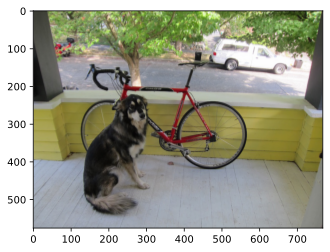

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mp
import PIL as pl
import cv2

image_path = '/content/darkflow-master/sample_img/sample_dog.jpg'
image =  mp.imread(image_path)
plt.imshow(image)

Query Image

In [ ]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = tfnet.return_predict(img)
img.shape


(576, 768, 3)

Extract Data

In [ ]:
tl = (result[1]['topleft']['x'], result[1]['topleft']['y'])
br = (result[1]['bottomright']['x'], result[1]['bottomright']['y'])
label = result[1]['label']

In [ ]:
print(label)

motorbike


Display Box

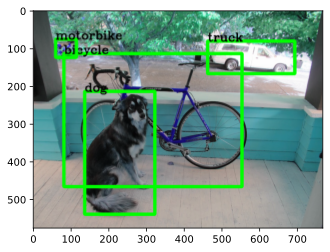

In [ ]:
for i in range(0,len(result)) :
  img = cv2.rectangle(img, (result[i]['topleft']['x'], result[i]['topleft']['y']), (result[i]['bottomright']['x'], result[i]['bottomright']['y']), (0, 255, 0), 7)
  img = cv2.putText(img, result[i]['label'], (result[i]['topleft']['x'], result[i]['topleft']['y']), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
plt.imshow(img)

# EMINST Data

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

In [ ]:
!pip install emnist

In [ ]:
from emnist import list_datasets

In [ ]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [ ]:
from emnist import extract_training_samples
from emnist import extract_test_samples

test_1, test_labels_1 = extract_test_samples('letters')
train_1, train_labels_1 = extract_training_samples('letters')

train_labels_1 = list(np.asarray(train_labels_1) + 10)
test_labels_1 = list(np.asarray(test_labels_1) + 10)

test_2, test_labels_2 = extract_test_samples('digits')
train_2, train_labels_2 = extract_training_samples('digits')

Test_images, Test_labels = np.concatenate((test_1, test_2), axis=0),np.concatenate((test_labels_1, test_labels_2), axis=0)
Train_images, Train_labels = np.concatenate((train_1, train_2), axis=0),np.concatenate((train_labels_1, train_labels_2), axis=0)

print(Test_images.shape)
print(Test_labels.shape)


print(Train_images.shape)
print(Train_labels.shape)

(60800, 28, 28)
(60800,)
(364800, 28, 28)
(364800,)


In [ ]:
Train_images.shape

(364800, 28, 28)

In [ ]:
train_1.shape

(124800, 28, 28)

In [ ]:
train_2.shape

(240000, 28, 28)

In [ ]:
Train_images[55].shape

(28, 28)

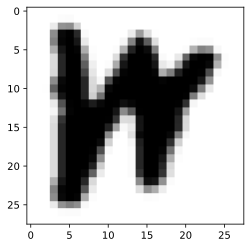

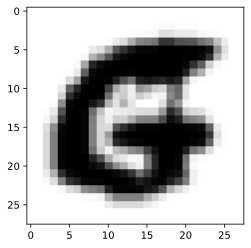

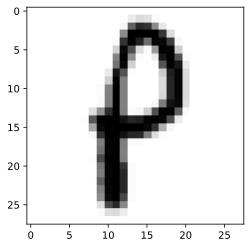

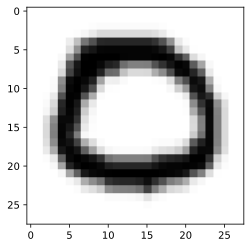

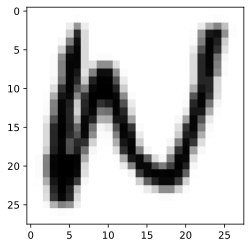

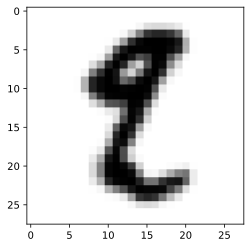

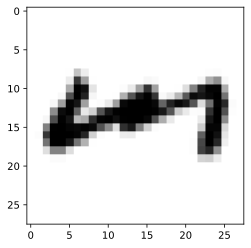

In [ ]:
#Let's print first 10 letters from EMINST training samples
for i in range(7):
    first_ten_letters = Train_images[i].reshape((28, 28))
    plt.imshow(first_ten_letters, cmap = 'binary')
    #plt.axis("off")
    plt.show()

# Gonna Synthisize my out data set with boxes...

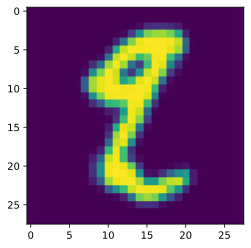

In [ ]:
plt.imshow(Train_images[5])

In [ ]:
print(Train_labels[:6])

[33 17 26 25 33 27]


In [ ]:
print(len(Train_images[50]))

28


In [ ]:
print(str(10))

10


In [ ]:
import random
from PIL import Image
from xml.etree import ElementTree as ET

dataset_size = 80
for set_size in range(0,dataset_size) :

  #Blank Image
  temp_img = np.zeros([200,200],dtype=np.uint8)

  index = set_size
  annot = "<annotation>\n\
    <folder>VOC2007</folder>\n\
    <filename>" + str(index) + ".jpg</filename>\n\
    <source>\n\
      <database>EMNIST</database>\n\
      <annotation>EMNIST</annotation>\n\
      <image>EMNIST</image>\n\
      </source>\n\
        <owner>\n\
        <name>Gregory Cohen, Saeed Afshar, Jonathan Tapson, and Andre van Schaik</name>\n\
        </owner>\n\
          <size>\n\
            <width>200</width>\n\
            <height>200</height>\n\
            <depth>1</depth>\n\
            </size>\n\
            <segmented>0</segmented>"
  stack = random.randint(7, 15)
  for i in range(0 , stack) :
    j = random.randint(0 , len(Train_images) )
    anchor = ( random.randint(0,200 - len(Train_images[j]-1)), random.randint(0,200-len(Train_images[j])-1))
    temp_img[anchor[0]:anchor[0]+len(Train_images[j]),anchor[1]:anchor[1]+len(Train_images[j])] += Train_images[j]
    annot += "<object>\n\
              <name>" + str(Train_labels[j]) + "</name>\n\
              <pose>Left</pose>\n\
              <truncated>0</truncated>\n\
              <difficult>0</difficult>\n\
                <bndbox>\n\
                  <xmin>" + str(anchor[1]) + "</xmin>\n\
                  <ymin>" + str(anchor[0]) + "</ymin>\n\
                  <xmax>" + str(anchor[1] + len(Train_images[j])) + "</xmax>\n\
                  <ymax>" + str(anchor[0] + len(Train_images[j])) + "</ymax>\n\
                </bndbox>\n\
              </object>\n"
  annot += "</annotation>"

  tree = ET.XML(annot)
  with open("/content/darkflow-master/test/training/annotations/" + str(index) + '.xml', "wb") as f :
    f.write(ET.tostring(tree))
  
  im = Image.fromarray(temp_img)
  im.save("/content/darkflow-master/test/training/images/"  + str(index) + ".jpg")
  #temp_img = temp_img.paste(img2, (0,0))

# Training

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

AttributeError: ignored

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
tf.config.list_physical_devices('GPU')

AttributeError: ignored

In [ ]:
with tf.device('/device:GPU:0') :
  !python flow --model cfg/tiny-yolo-voc-3c.cfg --load bin/yolo.weights --train --annotation test/training/annotations --dataset test/training/images

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.










Parsing ./cfg/yolo.cfg
Parsing cfg/tiny-yolo-voc-3c.cfg
Loading bin/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.007754087448120117s

Building net ...

Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------



       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)

 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_

In [ ]:
!zip -r /content/darkflow-master/test/training.zip /content/darkflow-master/test/training

updating: content/darkflow-master/test/training/ (stored 0%)
updating: content/darkflow-master/test/training/annotations/ (stored 0%)
updating: content/darkflow-master/test/training/annotations/30.xml (deflated 90%)
updating: content/darkflow-master/test/training/annotations/0.xml (deflated 88%)
updating: content/darkflow-master/test/training/annotations/8.xml (deflated 85%)
updating: content/darkflow-master/test/training/annotations/20.xml (deflated 90%)
updating: content/darkflow-master/test/training/annotations/36.xml (deflated 89%)
updating: content/darkflow-master/test/training/annotations/38.xml (deflated 85%)
updating: content/darkflow-master/test/training/annotations/15.xml (deflated 88%)
updating: content/darkflow-master/test/training/annotations/35.xml (deflated 90%)
updating: content/darkflow-master/test/training/annotations/12.xml (deflated 87%)
updating: content/darkflow-master/test/training/annotations/18.xml (deflated 89%)
updating: content/darkflow-master/test/training/

In [ ]:
from google.colab import files
files.download('/content/darkflow-master/test/training.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

files.download("/content/darkflow-master/test/training")